>Brain Tumor Segmentation using Deep Learning
>>Author: Young

# Overview

* Setup
* Create a custom `ItemList` with our custom dataset using fastai
* Get files and explore them
* Split the dataset into training/validation set
* Label the each training/validation dataset
* Transform per image
* Transform per batch(*)
* DataBunch
* Add test set(*)

# Setup

In [1]:
import torch, fastai, sys, os
from fastai.vision import *
import ants
from ants.core.ants_image import ANTsImage
from jupyterthemes import jtplot
sys.path.insert(0, './exp')
jtplot.style(theme='gruvboxd')

In [2]:
# Set a root directory
path = Path('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training')
path

PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training')

In [3]:
def is_mod(fn:str, mod:str)->bool:
    "Check if file path contains a specified name of modality used for MRI"
    import re
    r = re.compile('.*' + mod, re.IGNORECASE)
    return True if r.match(fn) else False

#TODO: Ensure no overalap between modalities

def is_mods(fn:str, mods:Collection[str])->bool:
    "Check if file path contains specified names of modality used for MRI"
    import re
    return any([is_mod(fn, mod) for mod in mods])

def _path_to_same_str(p_fn):
    "path -> str, but same on nt+posix, for alpha-sort only"
    s_fn = str(p_fn)
    s_fn = s_fn.replace('\\','.')
    s_fn = s_fn.replace('/','.')
    return s_fn

def _get_files(path, file, modality):
    """
    Internal implementation for `get_files` to combine a parent directory with a file 
    to make a full path to file(s)
    """
    p = Path(path)
    res = [p/o for o in file if not o.startswith('.') and is_mods(o, modality)]
    assert len(res)==len(modality) #TODO: Assert message
    return res

def get_files(path:PathOrStr, modality:Union[str, Collection[str]], 
                presort:bool=False)->FilePathList:
    "Return a list of full file paths in `path` each of which contains modality in its name"
    file = [o.name for o in os.scandir(path) if o.is_file()]
    res = _get_files(path, file, modality)
    if presort: res = sorted(res, key=lambda p: _path_to_same_str(p), reverse=False)
    return res

def _repr_antsimage(self):
    if self.dimension == 3:
        s = 'NiftiImage ({})\n'.format(self.orientation)
    else:
        s = 'AntsImage\n'
    s = s +\
        '\t {:<10} : {} ({})\n'.format('Pixel Type', self.pixeltype, self.dtype)+\
        '\t {:<10} : {}{}\n'.format('Components', self.components, ' (RGB)' if 'RGB' in self._libsuffix else '')+\
        '\t {:<10} : {}\n'.format('Dimensions', self.shape)+\
        '\t {:<10} : {}\n'.format('Spacing', tuple([round(s,4) for s in self.spacing]))+\
        '\t {:<10} : {}\n'.format('Origin', tuple([round(o,4) for o in self.origin]))+\
        '\t {:<10} : {}\n'.format('Direction', np.round(self.direction.flatten(),4))
    return s

In [4]:
# Modify the representation of `ANTsImage` object
ANTsImage.__repr__ = _repr_antsimage

# Create a custom ItemList for our custom dataset using fastai

*__Note: Set `NiftiImage`'s state `data` to Pytorch `Tensor` object__.*  <br>
Because it's going to be fed into `collate_fn` inside `DataLoader` as such.

In [5]:
class NiftiImage(ItemBase):
  "Support handling NIfTI image format" 
  #TODO: Extend the code so as to support various Python (medical) libraries that can read NIfTI format   
  def __init__(self, data:Union[Tensor,np.array], obj:ANTsImage, path:str): 
    self.data = data
    self.obj = obj
    self.path = path
    # Only works for a specific folder tree
    self.mod = self.path.split(".")[0].split("_")[-1]
  
  def __repr__(self): return str(self.obj) + '\t {:<10} : {}\n\n'.format('Modality', str(self.mod))

  def __getattr__(self, k:str):
    func = getattr(self.obj, k)
    if isinstance(func, Callable): return func
  
  def __setattr__(self, k, v):
    if k == 'obj':
        self.data = torch.tensor(v.numpy())
    return super().__setattr__(k, v)

  # This wraps ANTsPy's `plot` method to show NIfTI image
  def show(self, **kwargs):
    ants.plot(self.obj)

  # This wraps ANTsPy's `image_read` method to read NIfTI format
  @classmethod
  def create(cls, path:PathOrStr):
    nimg = ants.image_read(str(path))
    t = torch.tensor(nimg.numpy())
    return cls(t, nimg, path)

  def apply_tfms(self, tfms:List[Transform], *args, order='order', **kwargs):
    key = lambda o : getattr(o, order, 0)
    for tfm in sorted(listify(tfms), key=key): self = tfm(self, *args, **kwargs) #ascending order eg. [3,2,1] -> [1,2,3]
    return self


In [6]:
class MultiNiftiImage(ItemBase):
  "Support handling multi-channel NIfTI images"
  def __init__(self, obj:Tuple[NiftiImage]):
    self.obj = obj # type annotation violated when `subregionify` is used. Should be fixed.
    self.data = None
  
  def __repr__(self): 
        return f"Inside {self.__class__.__name__}:\n {[self.obj[i] for i in range(len(self.obj))]}"       
   
  def __getitem__(self, i):
        return self.obj[i]
        
  @classmethod
  def create(cls, paths:FilePathList):
    obj = tuple([NiftiImage.create(str(path)) for path in paths])
    return cls(obj)

  def apply_tfms(self, tfms:List[Transform], *args, order='order', **kwargs):
    self.obj = tuple([self.obj[i].apply_tfms(tfms, order, *args, **kwargs) for i in range(len(self.obj))])
    self.data = torch.stack([nft.data for nft in self.obj], dim=0)
    return self

  @property
  def data(self):
    return self._data

  @data.setter
  def data(self, _):
    self._data = ( torch.stack([nft.data for nft in self.obj], dim=0) 
                  if hasattr(self.obj[0], "data") 
                  else torch.stack([torch.tensor(nft.numpy()) for nft in self.obj], dim=0) )

#TODO: def show()
  #TODO: Find a way to show images neatly (w/o cluttering the cell)

In [7]:
class NiftiImageList(ItemList):
     
  def __repr__(self)->str: 
    return '{} ({} items)\n{}\nPath: {}'.format(self.__class__.__name__, 
                                                len(self.items), show_some(self.items, n_max=4, sep="\n"), 
                                                self.path)  
  def get(self, i)->NiftiImage:
    fn = str(self.items[i])
    return NiftiImage.create(fn)


In [8]:
class MultiNiftiImageList(ItemList):

  def __repr__(self)->str: 
    return '{} ({} items)\n{}\nPath: {}'.format(self.__class__.__name__, 
                                                len(self.items), show_some(self.items, n_max=4, sep="\n"), 
                                                self.path)  
  def get(self, i)->MultiNiftiImage:
    filepaths = [str(self.items[i][x]) for x in range(len(self.items[i]))]
    return MultiNiftiImage.create(filepaths)

  @classmethod
  def from_folder(cls, folderpaths:FilePathList, modality:Union[str, Collection[str]], 
                  presort:bool=False, **kwargs):
    """
    This method assumes a list of full paths to the desired files's parent folders 
    and returns NiftiImageTupleList whose item is a nested list with each sublist 
    belonging to its parent folder
    -------------------------------------------------------------------------
        Test:
        assert len(filepaths) == len(path)
        
    """
    filepaths=[]
    for fp in folderpaths:
      filepath = get_files(fp, modality=modality, presort=True)
      filepaths.append(filepath)
        
    return cls(items=filepaths, path=path, **kwargs)
    

# Get files and explore them

In [ ]:
############################# Sanity Check ############################
hgg_subdirs = (path/'HGG').ls()
lgg_subdirs = (path/'LGG').ls()
parent_folders = hgg_subdirs + lgg_subdirs

print("The number of folders parent to the files:", len(parent_folders))
multi_nifti = MultiNiftiImageList.from_folder(parent_folders, modality=['Flair', 'T1', 'T2', 'T1ce'])

print("Our custom Itemlist for our dataset:")
print(multi_nifti)

# print("Our custom ItemBase:")
# print(multi_nifti[0])

# print("MultiNiftiImage's data inspection")
#print(multi_nifti[0].data.shape)

In [10]:
multi_nifti = MultiNiftiImageList.from_folder(parent_folders, modality=['flair', 't1', 't2', 't1ce'])
multi_nifti # Index 0:flair, 1:t1, 2:t1ce, 3:t2 

MultiNiftiImageList (335 items)
[PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_flair.nii.gz')
 PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1.nii.gz')
 PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1ce.nii.gz')
 PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t2.nii.gz')]
[PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_flair.nii.gz')
 PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_t1.nii.gz')
 PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_t1ce.nii.gz')
 PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_t

In [11]:
seg_nifti = MultiNiftiImageList.from_folder(parent_folders, modality=['seg'])
seg_nifti

MultiNiftiImageList (335 items)
[PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_seg.nii.gz')]
[PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_seg.nii.gz')]
[PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_12_1/BraTS19_2013_12_1_seg.nii.gz')]
[PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_13_1/BraTS19_2013_13_1_seg.nii.gz')]...
Path: /home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training

In [12]:
multi_nifti[0], seg_nifti[0]

(Inside MultiNiftiImage:
  [NiftiImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (240, 240, 155)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, -239.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
 	 Modality   : flair
 
 , NiftiImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (240, 240, 155)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, -239.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
 	 Modality   : t1
 
 , NiftiImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (240, 240, 155)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, -239.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
 	 Modality   : t1ce
 
 , NiftiImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (240, 240, 155)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, -239.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
 	 Modality   : t2
 
 ], Inside MultiNiftiImage:
  

In [13]:
multi_nifti[0][3], seg_nifti[0][0]

(NiftiImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (240, 240, 155)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, -239.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
 	 Modality   : t2
 , NiftiImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (240, 240, 155)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, -239.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
 	 Modality   : seg
 )

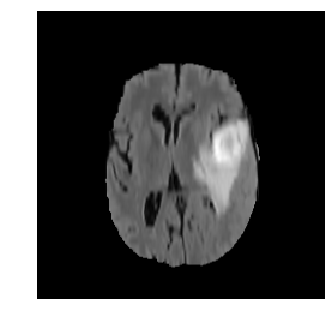

In [53]:
multi_nifti[0][0].plot(axis=2, slices=(0.5), figsize=4) # flair 

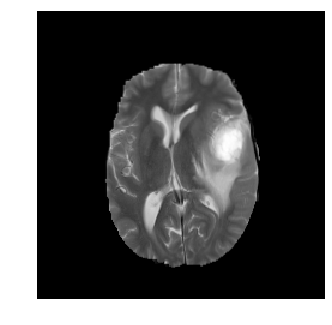

In [52]:
multi_nifti[0][3].plot(axis=2, slices=(0.5), figsize=4) #t2

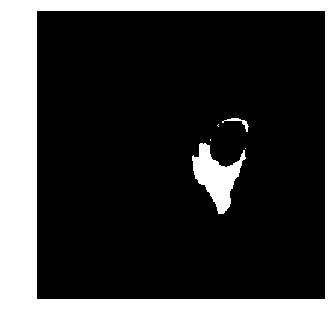

In [60]:
edema = seg_nifti[0][0].numpy()
edema[edema!=2] = 0
edema = ants.from_numpy(edema)
edema.plot(axis=2, slices=(0.5), figsize=4)

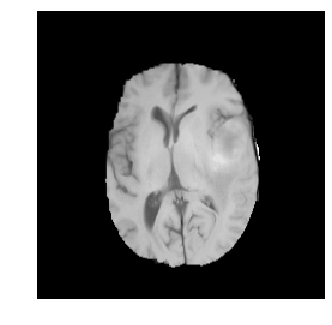

In [54]:
multi_nifti[0][1].plot(axis=2, slices=(0.5), figsize=4) #t1

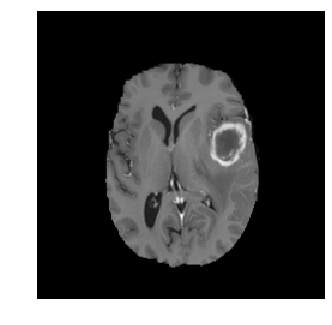

In [55]:
multi_nifti[0][2].plot(axis=2, slices=(0.5), figsize=4) #t1ce

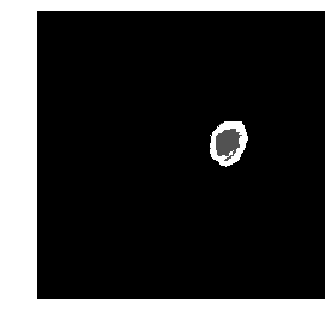

In [64]:
gross_tumor_core = seg_nifti[0][0].numpy()
gross_tumor_core[gross_tumor_core==2] = 0
gross_tumor_core = ants.from_numpy(gross_tumor_core)
gross_tumor_core.plot(axis=2, slices=(0.5), figsize=4)

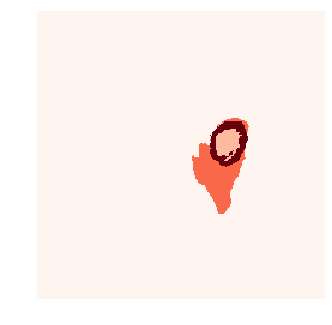

In [62]:
seg_nifti[0][0].plot(axis=2, slices=(0.5), figsize=4, cmap=plt.cm.Reds)

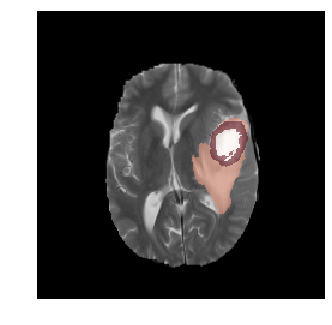

In [45]:
multi_nifti[0][3].plot(axis=2, slices=(0.5), figsize=4, 
                       overlay=seg_nifti[0][0].obj, overlay_cmap=plt.cm.Reds, overlay_alpha=0.5)

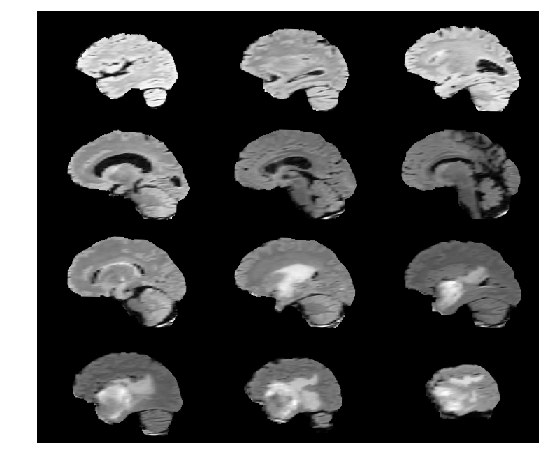

In [0]:
aimg = multi_nifti[0][3]
aimg.plot()

In [0]:
aimg_cropped = aimg.crop_indices((40,28,10), (200,220,138))
aimg_cropped

NiftiImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (160, 192, 128)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (40.0, -211.0, 10.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

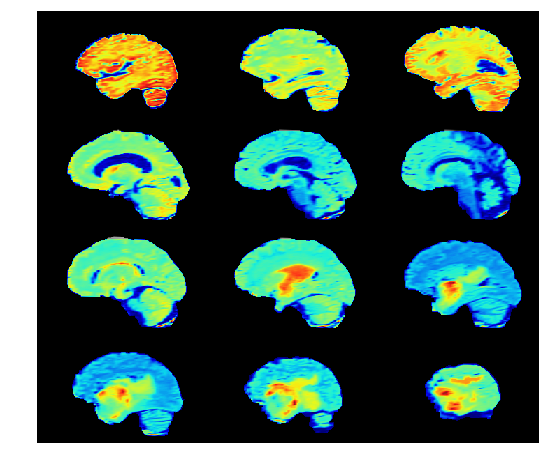

In [0]:
aimg.plot(aimg_cropped)

# Split the dataset into training/validation set

##  Get validation paths 

In [11]:
def get_parents(path:Path, pname:str, shuffle:bool=True, pct=0.2):
  "List a certain percent of items under a specified parent directory randomly or not"
  from random import shuffle
  ps = [d[i] for r,d,_ in os.walk(path) for i in range(len(d)) if Path(r).name==pname] 
  if shuffle: shuffle(ps)
  return ps[:round((pct*len(ps)))]

def write_val_list(fname:str='valid.txt', vals:List[str]=None):
  "Write a list of names into `fname` to be used for train/validation split"
  val_list = vals
  with open(fname, 'w') as f:
    f.write('\n'.join(val_list))
  print("{} items written into {}.".format(len(val_list), fname))

In [12]:
val_list = get_parents(path, 'HGG', pct=0.15) + get_parents(path, 'LGG', pct=0.1)
#print(len(val_list))
write_val_list('valid.txt', val_list)

47 items written into valid.txt.


In [13]:
!ls | grep valid.txt

valid.txt


## Monkey patch

In [14]:
def split_by_parents(self, valid_names:'ItemList')->'ItemLists':
  "Split the data by using the parent names in `valid_names` for validation."
  return self.split_by_valid_func(lambda o: o.parent.name in valid_names)

def split_by_pname_file(self, fname:PathOrStr, path:PathOrStr=None)->'ItemLists':
  "Split the data by using the parent names in `fname` for the validation set. `path` will override `self.path`."
  path = Path(ifnone(path, self.path))
  valid_names = loadtxt_str(path/fname)
  return self.split_by_parents(valid_names) 

def split_by_valid_func(self, func:Callable)->'ItemLists':
  "Split the data by result of `func` (which returns `True` for validation set)."
  valid_idx = [i for i,o in enumerate(self.items) if func(o[0])]
  return self.split_by_idx(valid_idx)
    
def _repr_labellist(self)->str:
  items = [self[i] for i in range(min(1,len(self.items)))]
  res = f'{self.__class__.__name__} ({len(self.items)} items)\n'
  res += f'x: {self.x.__class__.__name__}\n{show_some([i[0] for i in items], n_max=1)}\n'
  res += f'y: {self.y.__class__.__name__}\n{show_some([i[1] for i in items], n_max=1)}\n'
  return res + f'Path: {self.path}'

In [15]:
# Modify the methods of `MultiNiftiImageList` object
MultiNiftiImageList.split_by_parents = split_by_parents
MultiNiftiImageList.split_by_pname_file = split_by_pname_file
MultiNiftiImageList.split_by_valid_func = split_by_valid_func

In [16]:
# Modify the representation of `LabelList` object
LabelList.__repr__ = _repr_labellist

##  Split

In [17]:
############################ Sanity Check ############################
multi_nifti = multi_nifti.split_by_pname_file(fname='valid.txt', path=Path('.'))
print("Our ItemLists contains the file paths for each training and validation set:")
print(multi_nifti)

# print("We can index into an ItemBase inside training or validation set")
# print(multi_nifti.train[0])
# print(multi_nifti.valid[0])

Our ItemLists contains the file paths for each training and validation set:
ItemLists;

Train: MultiNiftiImageList (288 items)
[PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_flair.nii.gz')
 PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1.nii.gz')
 PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1ce.nii.gz')
 PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t2.nii.gz')]
[PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_flair.nii.gz')
 PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_t1.nii.gz')
 PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_t1ce.nii.gz')
 PosixPath('/ho

# Label the each training/validation dataset

In [18]:
from fastai.vision.data import SegmentationProcessor

__For both training and validation set, `SegmentationProcessor` will store the same states of class names and the number thereof.__

In [19]:
class NiftiSegmentationLabelList(NiftiImageList):
  "`ItemList` for NIfTI segmentatoin masks"
  _processor=SegmentationProcessor
    
  def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
    super().__init__(items, **kwargs)
    self.copy_new.append('classes')
    self.classes,self.loss_func = classes,None
    
  def reconstruct(self, t:Tensor): 
    obj = ants.from_numpy(t.numpy())
    path = self.path
    return NiftiImage(t, obj, path)

#TODO: def analyze_pred()

In [20]:
get_y_fn = lambda x: x[0].parent/Path(x[0].as_posix().split(os.sep)[-2]+'_seg.nii.gz')

In [21]:
""" 
 
 The following subregions comprise a different set of annotations
                       
                       (NCR/NET — label 1) | (ED — label 2) | (ET — label 4)
                                                    
 Whole Tumor(WT)     :          1                   1                1  
 Tumor Core(TC)      :          1                   0                1                     
 Enhancing Tumor(ET) :          0                   0                1 
                                          (1-Included/0-Excluded from a region)

NCR/NET -> the necrotic and non-enhancing tumor core
ED -> the peritumoral edema
ET -> the GD-enhancing tumor
"""   
subregion = np.array(['WT', 'TC', 'ET']) 
subregion

array(['WT', 'TC', 'ET'], dtype='<U2')

In [22]:
############################ Sanity Check ############################
multi_nifti = multi_nifti.label_from_func(get_y_fn, classes=subregion, label_cls=NiftiSegmentationLabelList)
print("Our LabelLists contains both in/dependent features for each training/validation set")
print(multi_nifti)

# print("We can see the class labels and the number thereof")
# print(multi_nifti.train.y.classes)
# print(multi_nifti.train.y.c)

Our LabelLists contains both in/dependent features for each training/validation set
LabelLists;

Train: LabelList (288 items)
x: MultiNiftiImageList
Inside MultiNiftiImage:
 [NiftiImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 155)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, -239.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
	 Modality   : flair

, NiftiImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 155)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, -239.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
	 Modality   : t1

, NiftiImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 155)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, -239.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
	 Modality   : t1ce

, NiftiImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 155)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : 

# Transform per image

In [23]:
def crop_3d(item:NiftiImage, do_resolve=False, *args, lowerind:Tuple, upperind:Tuple, **kwargs):
  "Crop 3-dimensional NIfTI image by slicing indices from lower to upper indices per image axis"
  cropped_item = item.obj.crop_indices(lowerind, upperind)
  item.obj = cropped_item
  return item

def standardize(item:NiftiImage, do_resolve=False, *args, **kwargs):
  "Standardize our custom itembase `NiftiImage` to have zero mean and unit std based on non-zero voxels only"
  arr = item.obj.numpy()
  arr_nonzero = arr[arr!=0]
  arr_nonzero = (arr_nonzero - arr_nonzero.mean()) / arr_nonzero.std()
  arr[arr!=0] = arr_nonzero / arr_nonzero.max()
  item.obj = ants.from_numpy(arr)
  return item

def subregionify(item:NiftiImage, do_resolve=False, *args, **kwargs): 
  "Combine the three annotations into 3 nested subregions: Whole Tumor(WT), Tumor Core(TC), Enhancing Tumor(ET)"
  arr = item.obj.numpy()
  wt_arr = arr.copy()
  wt_arr[wt_arr==1.] = 1.; wt_arr[wt_arr==2.] = 1.; wt_arr[wt_arr==4.] = 1.
  tc_arr = arr.copy()
  tc_arr[tc_arr==1.] = 1.; tc_arr[tc_arr==2.] = 0.; tc_arr[tc_arr==4.] = 1.
  et_arr = arr.copy()
  et_arr[et_arr==1.] = 0.; et_arr[et_arr==2.] = 0.; et_arr[et_arr==4.] = 1.
  return MultiNiftiImage([ants.from_numpy(arr) for arr in [wt_arr, tc_arr, et_arr]])

In [24]:
crop_3d = Transform(crop_3d, order=0)            # Applied to 'x' first then `y` for a implementation detail with overwrite
standardize = Transform(standardize, order=1)    # Only applied to 'x'
subregionify = Transform(subregionify, order=1)  # Only applied to 'y'

x_transform = [crop_3d, standardize]
y_transform = [crop_3d, subregionify]

In [25]:
############################ Sanity Check ############################ 
"We can delegate transform list to the `ItemBase` so it is lazily applied only when called"
multi_nifti = (multi_nifti.transform((x_transform, x_transform), tfm_y=False, lowerind=(40,28,10), upperind=(200,220,138))
                         .transform_y((y_transform, y_transform), lowerind=(40,28,10), upperind=(200,220,138)))

#print(Standardization:)
#print(multi_nifti.train[0][0].data.numpy().mean())
#print(multi_nifti.train[0][0].data.numpy().std())

#print(Subregionify our mask:)
# multi_nifti.train[0][1].data.shape

# GPU Setup

In [26]:
!nvidia-smi

Mon Jun 15 19:55:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:00:06.0 Off |                    0 |
| N/A   36C    P0    41W / 250W |   3108MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:00:07.0 Off |                    0 |
| N/A   53C    P0   137W / 250W |  25523MiB / 32480MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [27]:
# Reset your current device (if necessary)
torch.cuda.set_device(0)
# Check change's been made
torch.cuda.current_device()

0

# DataBunch(*)

In [28]:
multi_nifti = (MultiNiftiImageList.from_folder(parent_folders, modality=['Flair', 'T1', 'T2', 'T1ce'])
               .split_by_pname_file(fname='valid.txt', path=Path('.'))
               .label_from_func(get_y_fn, classes=subregion, label_cls=NiftiSegmentationLabelList)
               .transform((x_transform, x_transform), tfm_y=False, lowerind=(40,28,10), upperind=(200,220,138))
               .transform_y((y_transform, y_transform), lowerind=(40,28,10), upperind=(200,220,138))
               .databunch(bs=1, collate_fn=data_collate, num_workers=0))

In [29]:
x_train, y_train = next(iter(multi_nifti.train_dl))

In [30]:
x_train.shape, y_train.shape

(torch.Size([1, 4, 160, 192, 128]), torch.Size([1, 3, 160, 192, 128]))

In [34]:
y_train.shape

torch.Size([1, 3, 160, 192, 128])

In [35]:
"hello" + "world"

'helloworld'